# Behavior Exploratory Data Analysis

This notebook takes a visual tour through the behavioral data to help gain some intuition about the task. The plots in this notebook inform the modeling work we will do in the next notebook (B3-rt_modeling.ipynb). The cells in this notebook are all meant to be run in succession starting with the cell below which imports libraries and loads our data.

In [1]:
import pandas as pd
from ipywidgets import interact
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from utils import select_subjects

sns.set(style='whitegrid', font_scale=1.5)

behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')

# reduce to non-excluded subjects and trials with responses
subjects = select_subjects('both')
behavior = behavior[behavior.participant_id.isin(subjects)]

# merge demographic info (sex, age, mri scanner type)
demo = pd.read_csv('../data/participants.tsv', sep='\t', na_values='n/a')
behavior = pd.merge(behavior, demo, on='participant_id')

# Validating our Dependent Measures 

There are two main behavioral measures of interest from the MSIT task that we would be interested in analyzing:
1. response times
2. response accuracy

From our initial preprocessing and subject exclusion we've already screened out subjects with exceptionally high counts of non-responses and errors suggesting an inability to comprehend or engage in the task. Here, we look at the remaining subjects to ensure that we have sufficient data to analyze each of these variables. Based on the exclusion criteria visualizations, it looks as if we will be able to analyze response times, but won't have enough error trials to analyze response accuracy, but we verify that here.

Below, we look at error counts across subjects. We first screen out non-response trials and trials where the response time was too fast (< 200 ms) to be a valid behavioral response.

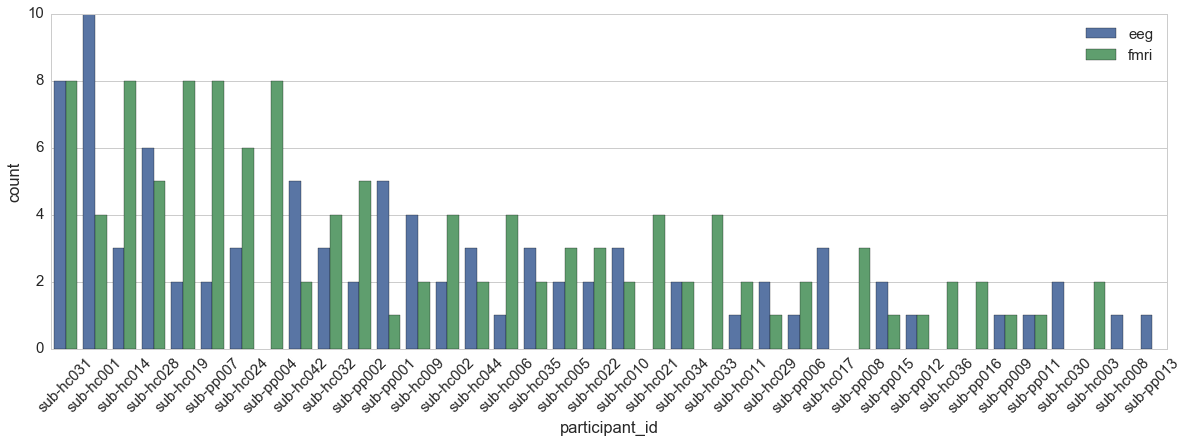

In [2]:
behavior = behavior[behavior.no_response == 0]
behavior = behavior[behavior.fast_rt == 0]

error_data = behavior[behavior.error == 1]
plt.figure(figsize=(20, 6))
sns.countplot(data=error_data, x='participant_id', hue='modality', order=error_data['participant_id'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(loc=1)
plt.show()

Our error counts range from 0 to ... 8. So very clearly we do not have enough data to work with here for analyzing response accuracy. This was to be expected as MSIT is not a task designed to elicit many errors. 

Given that errors are not of interest given the trial counts, we exclude error and post-error trials from here on out for our exploration. This is commonly done since when looking at response times for different factors, we want to exclude the confounding influence of the error. Similarly, post-error trials are also commonly excluded because they represent a different process (i.e. responding to the previous error) than typical trials not following an error. Obviously, this is an assumption and the post-error dynamics are by no means restricted to exactly one trial for every subject, but it is a reasonable assumption from the literature and so we follow custom.

Below, we plot valid response trial counts to get a sense of the amount data we have to work with.

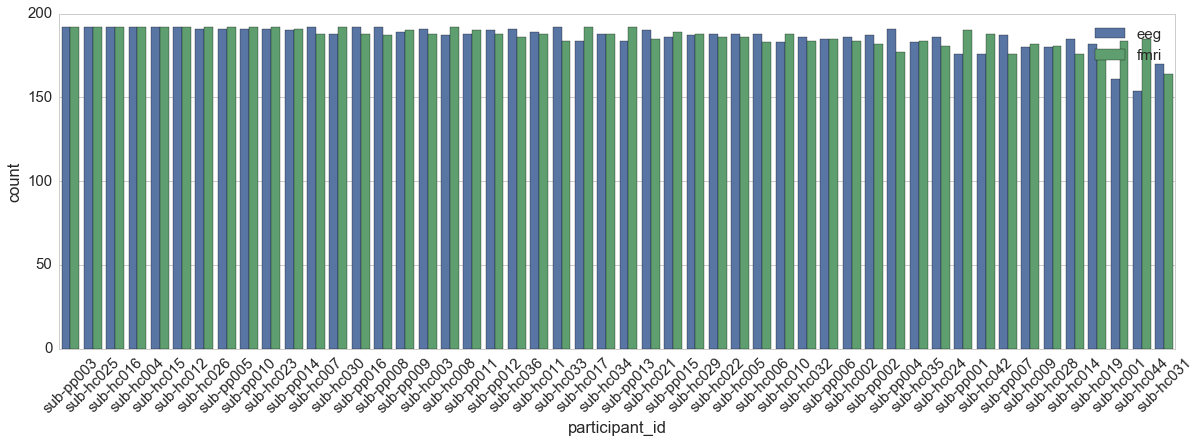

In [3]:
behavior = behavior[behavior.error == 0]
behavior = behavior[behavior.post_error == 0]

plt.figure(figsize=(20, 6))
sns.countplot(data=behavior, x='participant_id', hue='modality', order=behavior['participant_id'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(loc=1)
plt.show()

Not a very pretty or interesting plot to look at, but it confirms that all of the subjects who weren't excluded have a high level of valid trials for which response times can be analyzed. The minimum count looks to be about 175 trials which is approximately 90% of the total 196 trials administered. This means all subjects have 90% or greater of data to work with.

# Experimental Manipulations Effects on Response Time

Now that we've validated response time as a dependent measure, let's visualize the effects of the experimental manipulations on response times. There are two main manipulations that could affect response time:
- The imaging modality that the data were collected in: EEG or fMRI
- The trial type in the task: incongruent or congruent

The main finding in the MSIT task is that incongruent stimuli, those with a source of response interference, take longer to respond to than congruent stimuli. This has been a very robust effect and so we expect to find this in the data as well.

Another finding that has been reported in the literature, is that response times in the scanner are slower than response times outside of the scanner (FIND REFERENCE AND REASON). Given this, we also expect the EEG response times to be faster on average than the fMRI subjects. There is one potential confounder here in that the mri version of the task was always run first. This leaves open the possibility that there was a practice effect and that they were better and thus faster at the task for the EEG. Given, the lengths of the task, I wouldn't expect this effect to be substantial, but we will explore it further in a section below.

We look at the 2x2 interaction plot below to get a sense of these effects.

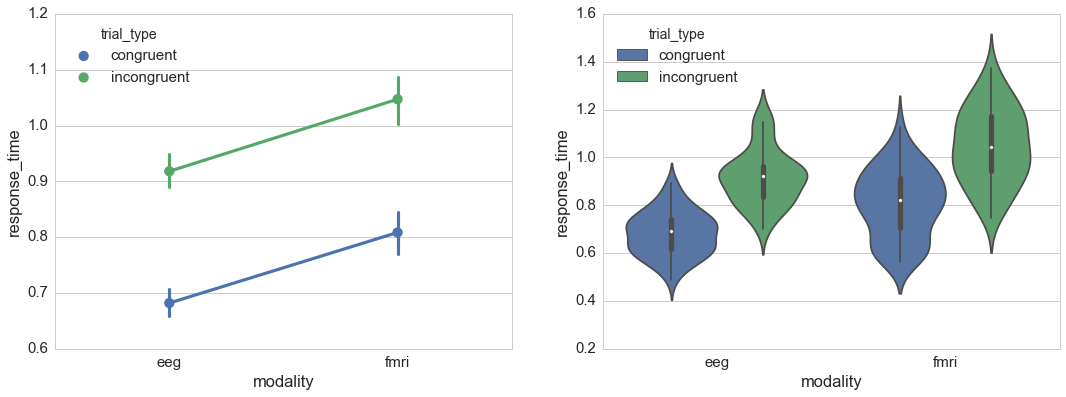

In [4]:
f, axs = plt.subplots(1, 2, figsize=(18, 6))
sub_summ = behavior.groupby(['participant_id', 'modality', 'trial_type'], as_index=False).response_time.mean()
sns.pointplot(data=sub_summ, x='modality', y='response_time', hue='trial_type', ax=axs[0], show=False)
sns.violinplot(data=sub_summ, x='modality', y='response_time', hue='trial_type', ax=axs[1], show=False)
plt.show()

From the plots, we clearly see main effects of both modality and trial type. Luckily, these are both in the direction as expected: incongruent trials are slower than congruent trials and fmri trials are slower than eeg trials. There doesn't seem to be really any interaction effect at all.

We fit a quick linear model below just to get estimated effect sizes (coefficients). Ignore all of the p-values and other statistics as the tests are not set up correctly.

In [5]:
res = smf.ols(formula='response_time ~ modality + trial_type + modality*trial_type', data=sub_summ).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          response_time   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     73.34
Date:                Tue, 22 May 2018   Prob (F-statistic):           7.61e-32
Time:                        12:18:59   Log-Likelihood:                 128.47
No. Observations:                 200   AIC:                            -248.9
Df Residuals:                     196   BIC:                            -235.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

From the coefficients above, we can see that: 
- **incongruent trials are on average 228 ms slower than congruent trials** 
- **fMRI trials are on average 131 ms slower than EEG trials** 
- **the interaction is pretty much zero**


One important thing to remind ourselves at this point is that all of the plots and summaries so far have thrown away a lot of information in the data. Namely we have swept all of the within subject trial variability under the rug by looking only at subject condition level means. 

While there is clearly an effect at the level of participant means, there are multiple ways in which this effect could be realized in actual individuals. For example, the difference in means could be solely due to shifts in the response time distributions, but it could also be realized by a greater tail in the incongruent condition or a combination of these and more.

To get a better understanding of this, we plot the full response time distributions below. Use the ipywidgets selector to sift from the group distributions through each individual subject to get a feel for the variability.

In [6]:

def plot_rts(subject):
    f, axs = plt.subplots(2, 2, figsize=(16, 6))
    
    trial_types = ['congruent', 'incongruent']
    mods = ['eeg', 'fmri']
    
    if subject != 'group':
        sub_behavior = behavior[behavior.participant_id == subject]
    else:
        sub_behavior = behavior
    
    for ax, mod in zip(axs[0, :], mods):
        mod_behavior = sub_behavior[sub_behavior.modality == mod]
        for tt in trial_types:
            sns.distplot(mod_behavior[mod_behavior.trial_type == tt].response_time, ax=ax)
        ax.legend(trial_types, loc='best')
        ax.set_xlabel('')
        ax.set_title(mod)
        
    for ax, tt in zip(axs[1, :], trial_types):
        tt_behavior = sub_behavior[sub_behavior.trial_type == tt]
        for mod in mods:
            sns.distplot(tt_behavior[tt_behavior.modality == mod].response_time, ax=ax)
        ax.legend(mods, loc='best')
        ax.set_title(tt)
            
    plt.tight_layout()
    plt.suptitle(subject)
    plt.show()
    
interact(plot_rts, subject=['group'] + subjects);

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc3ViamVjdCcsIG9wdGlvbnM9KCdncm91cCcsICdzdWItaGMwMDEnLCAnc3ViLWhjMDAyJywgJ3N1Yi1oYzAwMyfigKY=


These plots clearly reveal that the mean difference is not just due to a shift in the distributions. Rather it seems that there is both a shift in the distributions, but also the incongruent distribution appears to be much more spread and right skewed.

This suggests that there is potentially a lot more information to be gained by modeling the response time distributions in greater detail and we dive more into this modeling in the next notebook (B3-rt_modeling.ipynb).

# Temporal Pattern Effects on Response Time

So far as we've been exploring the response times, we have been implicitly making a rather large assumption: that the trials are indepedent of one another. As much as we might wish this to be the case for statistical modeling purposes, the truth is that the trials are run sequentially and thus we would expect there to be potential temporal pattern effects on response times.

For example, these could include:
- Global Time Effects: 
    - Practice Effect: People can get better at the task and respond faster over the course of the experiment as they become better practiced.
    - Arousal and Engagement: People can lose interest and or get tired as the experiment progresses. Psychology experiments typically aren't the most engaging activities (a tradeoff for experimental control) and so this is a very common issue.
- Local Trial Sequence Effects:
    - Trial Type Sequence Effects: One of the most commonly investigated sequence effects that has been investigated is the trial type sequence effect. There is a lot of literature looking at "post-conflict adaptation". This refers to the theory that one is better primed and prepared for a difficult trial with conflict (incongruent trials) if one has just recently experienced an incongruent trial compared to having experienced a congruent trial. The most common approximation for looking at this is to plot n-1 sequence means.
    - Motor Response Sequences: It could be that successive motor responses with the same finger are slightly faster due to motor priming for example.
    - Flanker Interference Sequences: It could be that one is better able to ignore or even less able to ignore flanker interferences if they were the same as on recent trials.
- Other Longer Length Frequency Effects: There could also be other longer frequency effects. For example, it has been shown that subject's response times are sensitive to changes in the relative frequencies of different experimental conditions. If the difficult trial type is more common, response times will be faster than if they are relatively rare [REF NEEDED]. As part of the design, the relative frequency of the two trial types was kept fairly even (more than 3 repetitions of each in a row were prevented and the trial counts are even) so this will likely not have much influence. We confirmed that the relative frequencies were pretty even when we were validating the task design in the behavior preprocessing notebook.

Due to the relative complexity of the MSIT stimuli, there are a lot of different factors that could have sequence effects. However, we do not really have enough data to look at all of these with proper resolution. Thus we restrict ourselves to global time effects and trial type sequence effects. 

## Global Time Effects

To look at global trends in the data we plot the response times across trials for each subject (or the average response time on each trial for the group plot) in the cell below. You can cycle from the group plot through each subject using the dropdown if you are running this notebook interactively. We split the line fits by trial type because a single line through the data would mask the global trends due to the difference between the two trial types.

In [138]:
def plot_global_time_trend(subject):
    if subject == 'group':
        data = behavior.groupby(['modality', 'trial', 'trial_type'], as_index=False).response_time.mean()
    else:
        data = behavior[behavior.participant_id == subject]
    sns.lmplot(data=data, x='trial', y='response_time', col='modality', hue='trial_type', col_order=['fmri', 'eeg'])
    plt.suptitle(subject)
    plt.show()

interact(plot_global_time_trend, subject=['group'] + subjects);

interactive(children=(Dropdown(description=u'subject', options=('group', 'sub-hc002', 'sub-hc003', 'sub-hc004', 'sub-hc005', 'sub-hc006', 'sub-hc007', 'sub-hc008', 'sub-hc009', 'sub-hc010', 'sub-hc011', 'sub-hc012', 'sub-hc014', 'sub-hc015', 'sub-hc016', 'sub-hc017', 'sub-hc021', 'sub-hc022', 'sub-hc023', 'sub-hc024', 'sub-hc025', 'sub-hc026', 'sub-hc028', 'sub-hc029', 'sub-hc030', 'sub-hc032', 'sub-hc033', 'sub-hc034', 'sub-hc035', 'sub-hc036', 'sub-hc042', 'sub-pp001', 'sub-pp002', 'sub-pp003', 'sub-pp004', 'sub-pp005', 'sub-pp006', 'sub-pp007', 'sub-pp008', 'sub-pp009', 'sub-pp010', 'sub-pp011', 'sub-pp012', 'sub-pp013', 'sub-pp014', 'sub-pp015', 'sub-pp016'), value='group'), Output()), _dom_classes=('widget-interact',))

At the group level, there doesn't seem to be too strong of a trend. In the fmri however, we do see an approximately 10 ms decrease across the full experiment. The EEG lines look pretty much flat however. This is consistent with a potential learning effect. We would expect this to have disappeared for the EEG since the EEG was always ran after the fMRI.

Browsing through individual subjects, we see a variety of trends. While some subjects show a similar decreasing trend consistent with a learning effect, others show no trend and some even show strong increasing trends (see sub-hc015 for example). This increasing trend could be a lack of engagement in the task (less engaged could mean slower to respond to the stimuli). Thus, even though the group trend is relatively mild, these global effects could be quite impactful for many of the subjects.

## Local Trial Type Sequence Effects

We take the n-1 sequence effects and use these as a simple proxy for potentially more complex local trial type sequence effects. The four different n-1 sequences are:
- ii: incongruent then incongruent
- ci: congruent then incongruent
- ic: incongruent then congruent
- cc: congruent then congruent

The two comparisons of interest are ii compared to ci trials and ic compared to cc trials. According to the adaptation hypothesis, one should be faster on ii compared to ci and on cc compared to ic trials because one has adapted to the trial type from the previous trial and is more prepared for that trial type. In reality, it is probably more complex than this as more than just the previous trials influence this, but we use this as a stand in proxy.

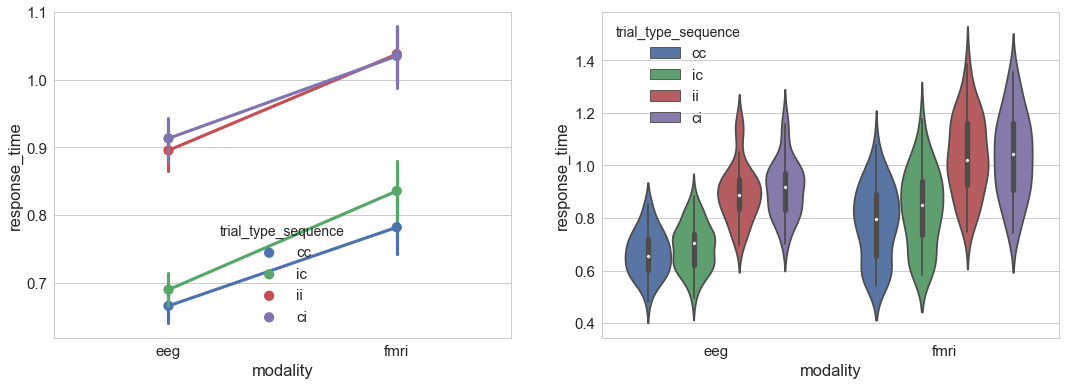

In [137]:
f, axs = plt.subplots(1, 2, figsize=(18, 6))
sub_summ = behavior.groupby(['participant_id', 'modality', 'trial_type_sequence'], as_index=False).response_time.mean()
sns.pointplot(data=sub_summ, x='modality', y='response_time', hue='trial_type_sequence', hue_order=['cc', 'ic', 'ii', 'ci'],
              ax=axs[0], show=False)
sns.violinplot(data=sub_summ, x='modality', y='response_time', hue='trial_type_sequence', 
               hue_order=['cc', 'ic', 'ii', 'ci'], ax=axs[1], show=False)
plt.show()

We see pretty much no difference between ci and ii trials. For the cc and ic trials, the cc trials are a bit faster (5-20 ms). Not sure why the effect might be larger in the fmri than in the eeg. 

Overall though, the effect is fairly small and so we will ignore it in future modeling though be wary that it is potentially present. It is never ideal to ignore a potential effect, but we don't really have the trial count or the iterations on task design to fully explore and model this effect so we will leave it aside for now.

# Confounding Variables

In addition to our visualizations above, we look at several confounding variables to see their effects on response times. These include:

- sex: No difference expected here
- age: Would expect response times to increase with age, but not necessarily the incongruent - congruent effect
- response button: Nothing expected here, but perhaps responses with certain fingers are faster 

First, we look at sex below:

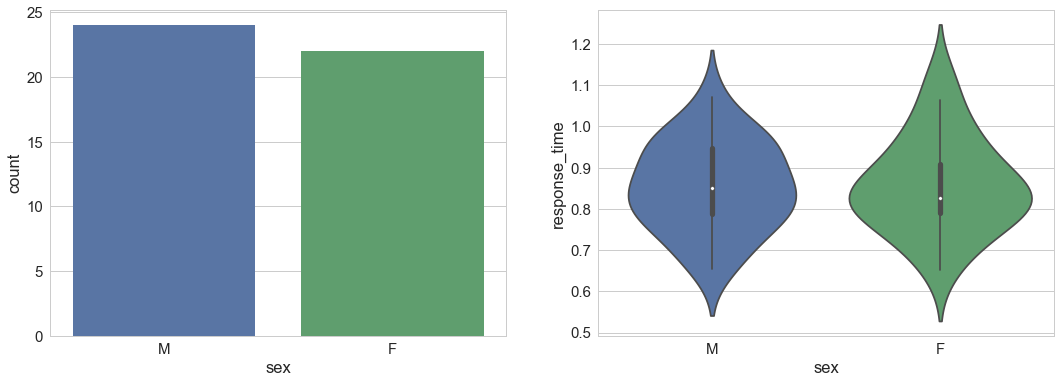

In [157]:
f, axs = plt.subplots(1, 2, figsize=(18, 6))
demo = behavior.groupby(['participant_id', 'sex'], as_index=False).response_time.mean()
sns.countplot(data=demo, x='sex', ax=axs[0])
sns.violinplot(data=demo, x='sex', y='response_time',  
               ax=axs[1], show=False)
plt.show()

We see very little difference between sexes. We have a very even balance as well.

Next we look at age below:

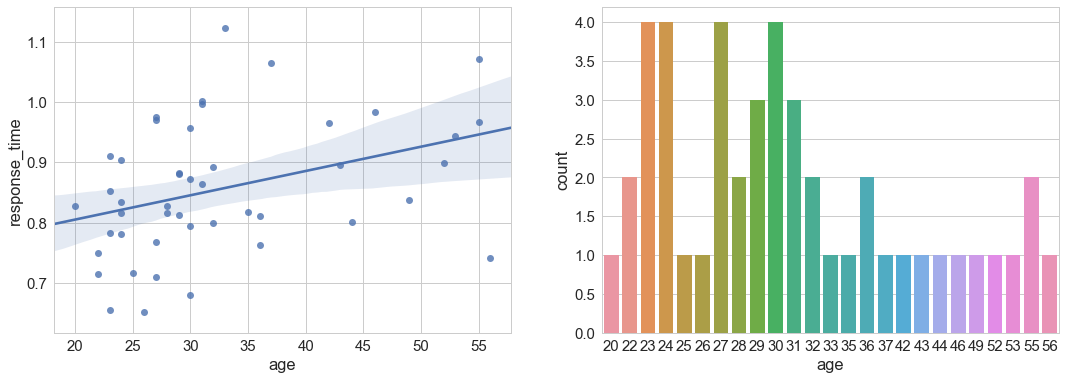

In [130]:
f, axs = plt.subplots(1, 2, figsize=(18, 6))
demo = behavior.groupby(['participant_id', 'age'], as_index=False).response_time.mean()
sns.regplot(data=demo, x='age', y='response_time', ax=axs[0])
sns.countplot(data=demo, x='age', ax=axs[1])
plt.show()

We have a fairly spread distribution of ages, but the bullk is clearly concentrated in the 20's. There seems to be a potential relationship with older subjects exhibiting longer response times. However, estimating the extent of the relationship is a bit confounded by the relative sparsity of older ages. 

Next we look at response button and its effect on response time.

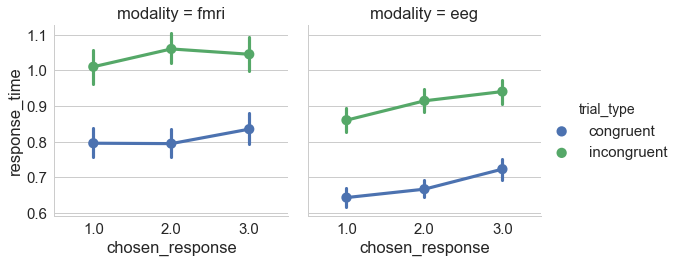

In [155]:
data = behavior.groupby(['participant_id', 'modality', 'chosen_response', 'trial_type'], as_index=False).response_time.mean()
sns.factorplot(data=data, x='chosen_response', y='response_time', col='modality', hue='trial_type', col_order=['fmri', 'eeg']);

Surprisingly, we see that response time increases from index finger (button 1) to middle finger (button 2) to ring finger (button 3). In hind sight, this is perhaps reasonable as the index finger is typically faster to react, followed by the middle finger and then ring finger. Luckily the trend is practically the same across trial types so it shouldn't interfere with our incongruent to congruent comparisons.

# Summary of Results

- Response times are our main outcome measure (there are not enough errors to model response accuracy)
- Incongruent trials are slower than congruent trials by 228 ms on average
- The difference in trial type response time distributions seems to be rather complex and not just due to a simple mean shift. This suggests we should model the full RT distribution differences in more detail.
- Subjects are slower to respond in the MRI compared to the MEG by 131 ms on average.
- We see a minimal effect of previous trial type on response times.
- We see varied global response time trends, suggesting we may need to detrend the data prior to fitting.
- No other large effects from other confounding variables that we explored (sex, age, response type)  